# Assignment 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
iris_label_space = np.array([0,1,2])

ion_X = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=np.arange(34))
ion_y = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=34, dtype="int")
ion_label_space = np.array([1,-1])

iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris['data'], iris['target'], random_state=2408)
ion_X_train, ion_X_test, ion_y_train, ion_y_test = train_test_split(ion_X, ion_y, random_state=2408)


def computeEuclideanNorm(vector: np.ndarray) -> float:
    """
        Computes the Euclidean norm of a vector by adding the squares of each value and square rooting
    """

    total = 0
    for i in range(0,vector.size):
        total += vector[i] * vector[i]
    
    return np.sqrt(total)


def calculateEuclideanDistance(v1: np.ndarray, v2: np.ndarray) -> float: 
    """
        Calculates the Euclidean distance between two points by computing the Euclidean norm of the vector distance
    """
    diff = np.subtract(v1, v2)
    return (computeEuclideanNorm(diff))


def computeDistances(sample: np.ndarray, training_set: np.ndarray) -> np.ndarray:
    """
        Calculates the distances from the given sample to all other points
    """

    result = np.zeros(len(training_set))
    for i in range(0, len(training_set)):
        result[i] = calculateEuclideanDistance(sample, training_set[i])

    return result


def computeMinimum(a: np.ndarray):
    """
        Calculates the minimum value of an array and returns it, along with its index
    """

    current_min = np.inf
    min_index = np.inf
    for n in range(a.size):
        if current_min > a[n]:
            current_min = a[n]
            min_index = n
    
    return current_min, min_index


def computeMaximum(a: np.ndarray):
    """
        Calculates the maximum value of an array and returns it, along with its index
    """
    current_max = -np.inf
    max_index = -np.inf
    for i in range(a.size):
        if current_max < a[i]:
            current_max = a[i]
            max_index = i

    return current_max, max_index


def calculateNNs(index: int, sample_y: int, y_training_set: np.ndarray, distances: np.ndarray):
    """
        Calculate the nearest numbers by taking in a matrix of distances
    """
    nn_dist_same = np.inf
    nn_index_same = -1
    nn_dist_diff = np.inf
    nn_index_diff = -1

    for i in range(len(y_training_set)):
        if i == index:
            continue  # skip comparing sample to itself

        dist = distances[index][i]

        if y_training_set[i] == sample_y:
            if dist < nn_dist_same:
                nn_dist_same = dist
                nn_index_same = i
        else:
            if dist < nn_dist_diff:
                nn_dist_diff = dist
                nn_index_diff = i

    return nn_dist_same, nn_index_same, nn_dist_diff, nn_index_diff

def calculateConformityScores(sample_X: np.ndarray, sample_y: np.ndarray, X_training_set, y_training_set):
    """
        Calculates the conformity score of a sample, using the NN of the same class / NN of diffetebt class
    """
    X_aug = np.concatenate((sample_X.reshape(1, -1), X_training_set), axis=0)
    y_aug = np.concatenate(([sample_y], y_training_set)) # additional sample will be the FIRST in augmented set

    n = len(X_aug)
    scores = np.zeros(len(X_aug))

    distances = np.zeros((n, n))
    for i in range(0, n):
        for j in range(i + 1, n):
            dist = calculateEuclideanDistance(X_aug[i], X_aug[j])
            distances[i][j] = dist
            distances[j][i] = dist

    for i in range(0, n):
        nn_dist_same, _, nn_dist_diff, _ = calculateNNs(i, y_aug[i], y_aug, distances)
        
        if nn_dist_same == 0:
            if nn_dist_diff == 0:
                scores[i] = 0
            else:
                scores[i] = np.inf
        else:
            scores[i] =  nn_dist_diff / nn_dist_same

    return scores


def calculatePValue(scores):
    """
        Calculate a given p-value given the conformity scores
    """
    test_score = scores[0]
    other_scores = scores[1:]

    rank = 0
    for score in other_scores:
        if score <= test_score:
            rank += 1

    p_value = (rank + 1) / len(scores)
    return p_value


def predict(Y, sample_X, X_training_set, y_training_set):
    """
        Makes a prediction by computing p-values of all possible labels and selecting the highest one, given the label space, 
    """

    Y_size = len(Y)
    p_values = np.zeros(Y_size)
    for i in range (0, Y_size):
        label = Y[i]
        scores = calculateConformityScores(sample_X, label, X_training_set, y_training_set)
        p_values[i] = calculatePValue(scores)

    _, p = computeMaximum(p_values)

    return Y[p]


def score(predictions, y_test_set):
    """
        Score the prediction set against the set of actual labels
    """
    return np.mean(predictions == y_test_set)


In [ ]:
iris_predictions = np.zeros(len(iris_X_test))

start = time.time()

for i in range(0, len(iris_X_test)):
    iris_predictions[i] = predict(iris_label_space, iris_X_test[i], iris_X_train, iris_y_train)

print("Score:", score(iris_predictions, iris_y_test))
print("\nCompleted in", time.time() - start, "seconds")

Score: 0.9736842105263158

Completed in 2.402384042739868 seconds


In [5]:
ion_predictions = np.zeros(len(ion_X_test))

start = time.time()

for j in range(0, len(ion_X_test)):
    ion_predictions[j] = predict(ion_label_space, ion_X_test[i], ion_X_train, ion_y_train)

print("Score:", score(ion_predictions, ion_y_test))
print("\nCompleted in", time.time() - start, "seconds")

Score: 0.6136363636363636

Completed in 55.75108337402344 seconds


## Sample Size vs. Error Rates

Here we perform experiments to determine the relationship between the size of the sample and the rate of error of the models on the Iris and Ionosphere datasets

### Iris Dataset

Progress: 100.00%
Completed in 46.036861181259155 seconds


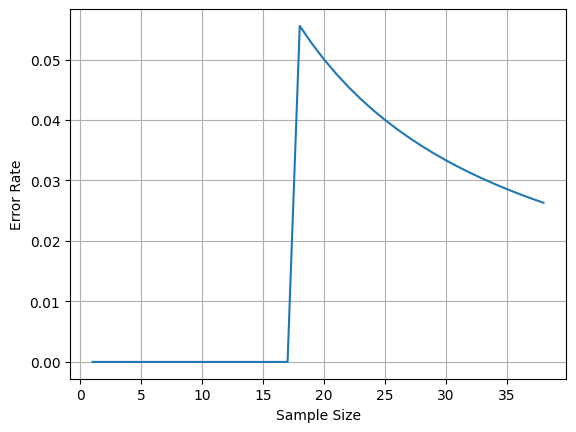

In [11]:
sample_sizes = np.arange(1, len(iris_X_test) + 1)
error_rates = np.zeros_like(sample_sizes, dtype=float)

start = time.time()

for i, size in enumerate(sample_sizes):
    current_X_test = iris_X_test[:size]
    current_y_test = iris_y_test[:size]
    current_predictions = np.zeros(size)

    for j in range(size):
        current_predictions[j] = predict(iris_label_space, current_X_test[j], iris_X_train, iris_y_train)
    
    s = score(current_predictions, current_y_test)
    error_rates[i] = 1 - s
    print("Progress: {:.2f}%".format(((i+1)/sample_sizes.size) * 100), end="\r")

plt.plot(sample_sizes, error_rates)
plt.xlabel('Sample Size')
plt.ylabel('Error Rate')
plt.grid(True)
print("\nCompleted in", time.time() - start, "seconds")

Here we can see that on very low sample sizes, there is little to no error. Then, at size 17, there is a huge spike of error, then tapering off to the final error error rate.

Progress: 100.00%
Completed in 536.473602771759 seconds


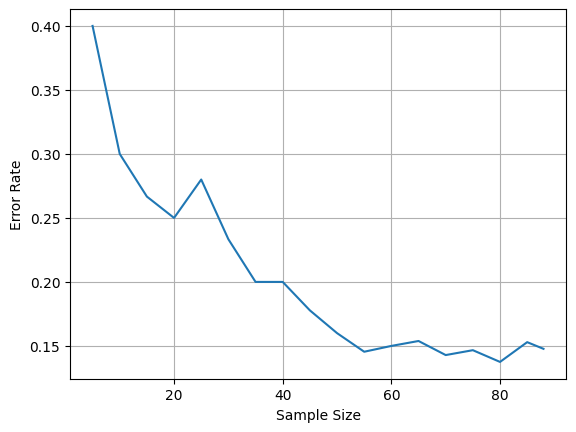

In [12]:
sample_sizes = np.append(np.arange(5, len(ion_X_test), 5), len(ion_X_test))
error_rates = np.zeros_like(sample_sizes, dtype=float)

start = time.time()

for i, size in enumerate(sample_sizes):
    current_X_test = ion_X_test[:size]
    current_y_test = ion_y_test[:size]
    current_predictions = np.zeros(size)

    for j in range(size):
        current_predictions[j] = predict(ion_label_space, current_X_test[j], ion_X_train, ion_y_train)
    
    s = score(current_predictions, current_y_test)
    error_rates[i] = 1 - s
    print("Progress: {:.2f}%".format(((i+1)/sample_sizes.size) * 100), end="\r")

plt.plot(sample_sizes, error_rates)
plt.xlabel('Sample Size')
plt.ylabel('Error Rate')
plt.grid(True)
print("\nCompleted in", time.time() - start, "seconds")